# Predicting Palmera Chocolate

We are going now to examine and treat our first series: palmera de chocolate.
    
Along this script we will:
    
    1) Paint the series, examine its autocorrelations and seasonality and get some useful insights.
    2) Apply different kinds of models to it, particularly time series models and machine learning models, also, when neuronal networks will be considered.
    3) Check the results we get from each method and extract our conclusions

# 1) Introductory examination

We import the required packages and our dataframe, and extract from it our series.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing tools from statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa as tsa
from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools as stto

from datetime import timedelta

plt.style.use('ggplot')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# train-test split library
from sklearn.model_selection import train_test_split

import random

# ERRORS
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import performance_metrics

# EXPONENTIAL SMOOTHING
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

#PROPHET
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 5

In [3]:
sep=";"
exit_path = "../../data/03_processed/" + "time_series.csv"

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [5]:
df=pd.read_csv(exit_path, sep=sep, parse_dates=True, index_col='order_date')

In [6]:
palmera_choco=df[df['product']=='palmera chocolate'][['units_ordered','festivo','weight']]

Now, we check our series, by plotting it and getting its first statistical values:

### 1.1) Series plot and first values

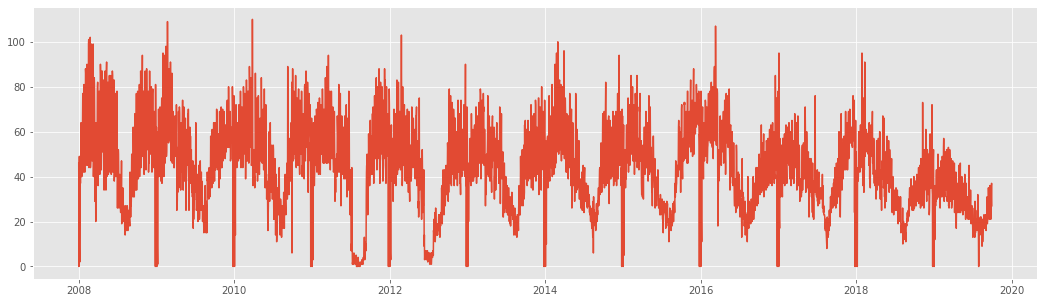

In [7]:
plt.plot(palmera_choco['units_ordered'])

#Important note: due to a bug in prophet series.plot() does not work

In [8]:
palmera_choco['units_ordered'].describe()

count    4291.000000
mean       43.670007
std        18.076184
min         0.000000
25%        32.000000
50%        43.000000
75%        55.000000
max       110.000000
Name: units_ordered, dtype: float64

As we can see, the series is possibly stationary: it has (at first glance) no trend, and no changes in variance.
    
We can also see that its mean value is about 43, and that there is no much difference between its mean and its median value, what is a good sign for the skewness.

We can also see that the series has a great dispersion in its daily values.

In order to smooth it and get some other insights, let's get and plot the series for the monthly average data.

### 1.2) Augmented Dickey-Fuller test

We are now going to check wether our series has any root bigger than 1 or it does not, in order to check its stationarity.

In a time series, if the process's characteristic equation presents a root with a value greater than 1, then the process will be non stationary.

So, in order to get stationarity for a determined process, all its roots of the characteristic equation must lie inside the unit circle—that is, have a modulus (absolute value) of less than one.

This is tested using the augmented Dickey-Fuller test.

The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models.

The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

In [9]:
adf_test_results = adfuller(palmera_choco['units_ordered'])

print("p-value: ", adf_test_results[1])
print("test value:", adf_test_results[0])
print("% confidence p-values: ", adf_test_results[4])

p-value:  4.860621460902781e-07
test value: -5.791487673614479
% confidence p-values:  {'1%': -3.43188633380603, '5%': -2.8622188674189872, '10%': -2.5671313664110107}


As we can see, the p value is about 0. Also, comparing the test value with the p-values for the 1% p-value (-5.79 to -3.43) we can see that we can clearly state that our series is stationary or trend-stationary.

### 1.3) Monthly averages and yearly seasonality

We are going to aggregate the data by month, stabiblishing their means, to check for the appearance of any patterns:

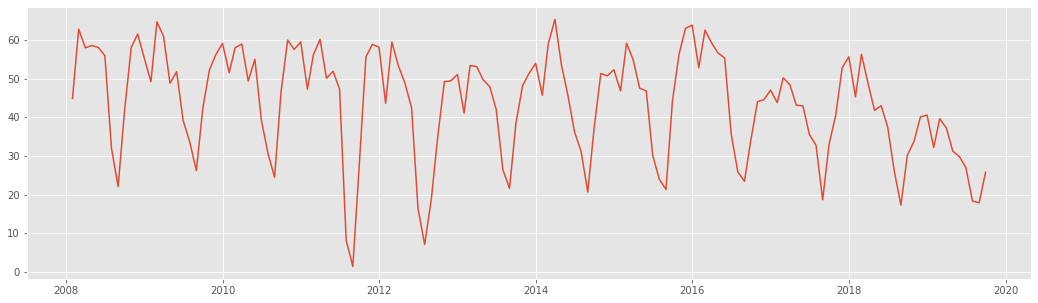

In [10]:
monthly  = palmera_choco.reset_index().groupby(pd.Grouper(key='order_date', freq='M'))['units_ordered'].mean()
plt.plot(monthly)
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as there is always a bump in orders during the middle the year.

We can see also that the series lacks a clear trend.

We also can see that the series presents minimums once a year, being more pronounced at 2011 and 2012.

We aree going to plot a couple of years to check where these minimums occur.

In [11]:
monthly.reset_index().head()

,order_date,units_ordered
0,2008-01-31,44.870968
1,2008-02-29,62.758621
2,2008-03-31,57.935484
3,2008-04-30,58.533333
4,2008-05-31,58.000000


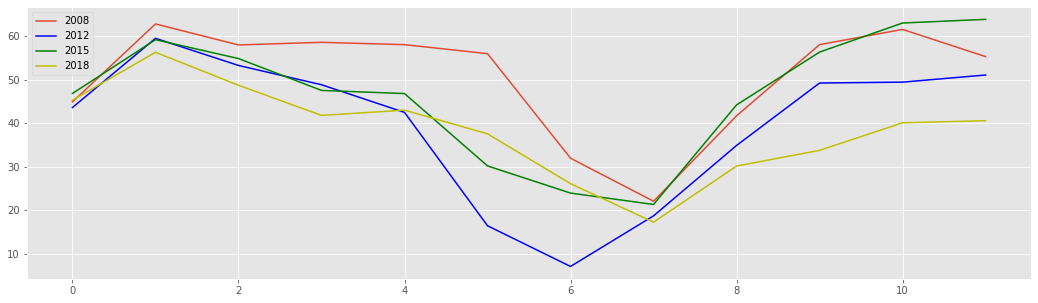

In [12]:
plt.plot(monthly['2008'].reset_index()['units_ordered'])
plt.plot(monthly['2012'].reset_index()['units_ordered'], color='b')
plt.plot(monthly['2015'].reset_index()['units_ordered'], color='g')
plt.plot(monthly['2018'].reset_index()['units_ordered'], color='y')
plt.legend(['2008','2012','2015','2018'])
plt.show()

As we can see, for 3 out of the 4 values plotted, the mininum value is found in the month of August.

For the fourth series, the minimum appears at July.

Maximums appear in January for all series.

We have found that there is a clear yearly seasonality in our series.

Talking about seasonality, we are going to check now for autocorrelations, and we will use the information that we have extracted for our graphs above to use it in our favor when looking for such autocorrelations.

### 1.3) Autocorrelation, ACF and PACF

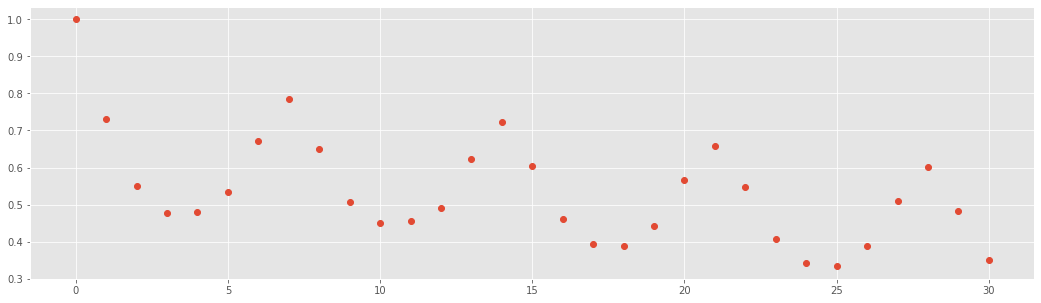

In [13]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

We check the plot with the plot_acf function that statsmodels also provides us, and that includes a visual p-value: a range(that can be seen below, red-shaded region) where values could be due to chance, up to a certain confidence level (or, to be more precise, a region of values that cannot be discarded as being being produced by chance):

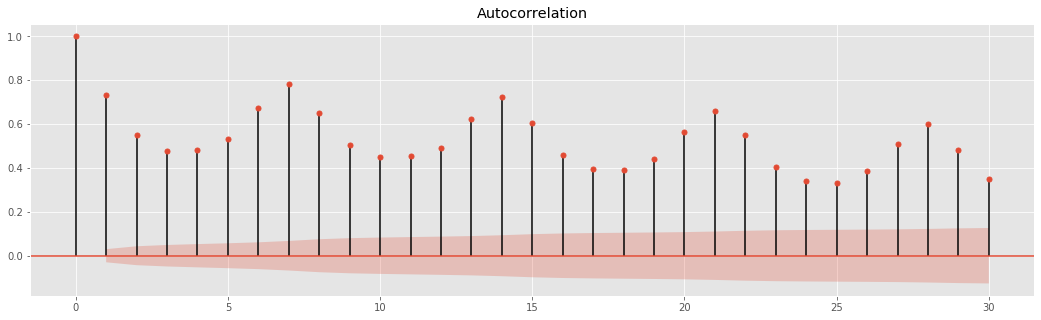

In [14]:
plot_acf(palmera_choco['units_ordered'], lags=30);

As we can see, our series presents both a strong relationship with its n-1 lag (correlation of about 0.75, and also a clear weekly autocorrelation (of about 0.8 - 0.75^6 ≈ 0.6).

As we know, if our process follows an AR(x) model, the value n will have a relation to value n-x of value alpha, then will present a correlation with the value n-2\*x of alpha^2, and a correlation of alpha^3 with the value n-3\*x and so on.

Also, appart from the stated, we cannot discard any of the correlations with the values up to the 7th.

Now, as we saw previously that a strong yearly seasonality existed, we are going now to check for autocorrelations in a more ample spectrum:

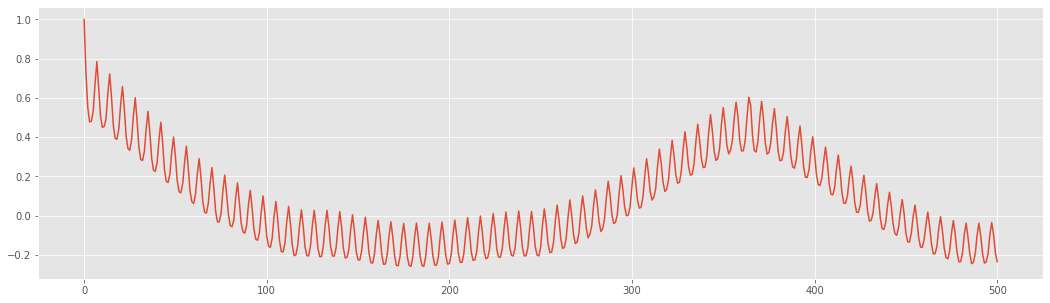

In [15]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=500)

plt.plot(p_choc_acf)

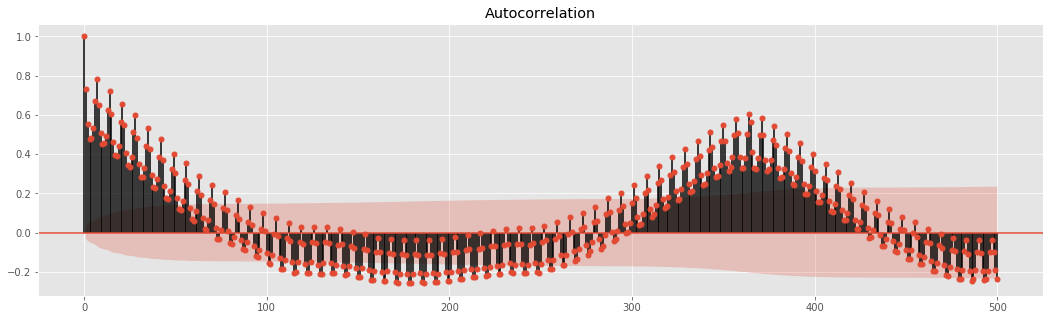

In [16]:
plot_acf(palmera_choco['units_ordered'], lags=500);

As we can see, there is a sinusoidal behaviour, and that the series presents a peak at lag 365.

We are checking that using our average monthly data, so we can get rid off the strong autocorrelations found in our daily series.

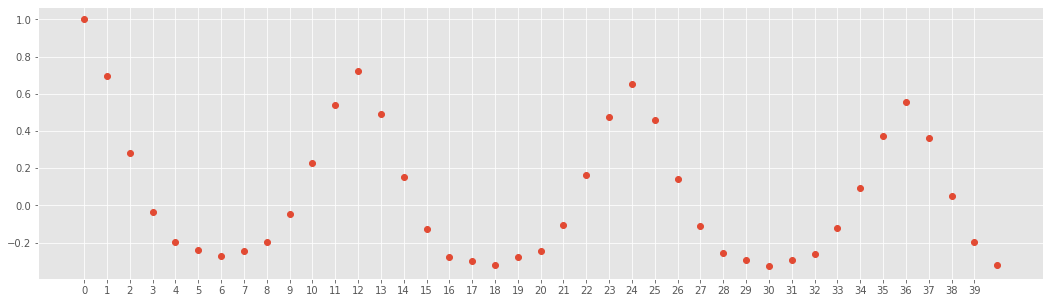

In [17]:
p_choc_acf=stto.acf(monthly, nlags=40)

plt.plot(p_choc_acf,  'o')
plt.xticks(list(range(40)));

We find a strong relationship involving each month with the same month of the previous year, showing, again, the yearly seasonality that we found during section 1.2.

Finally, we are checking the partial autocorrelation function, that shows us how much residual information is explained by adding a new lag.

PACF, instead of finding correlations of present with lags like ACF, finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

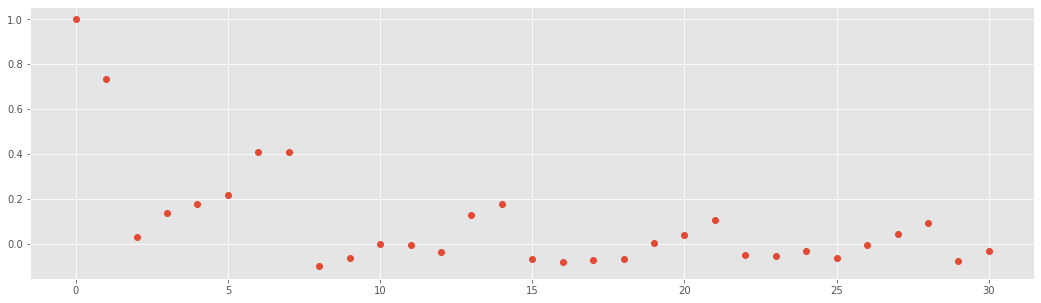

In [18]:
p_choc_acf=stto.pacf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

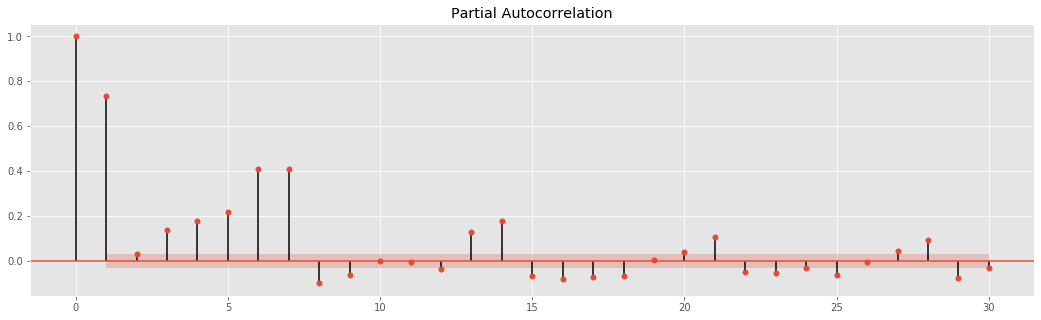

In [19]:
plot_pacf(palmera_choco['units_ordered'], lags=30);

The PACF confirms us what we saw in the acf: the series presents a strong correlation with its first lag (being most of the rest of the spikes merely the result of the propagation of the autocorrelation at lag 1), but there is also a strong autocorrelation with lags 6 and 7. So, in general, autoregressive models of order 7 will be needed to explain the series.

### 1.4) Series decomposition

Finally, to get a better grip on our series before studying it by any methods, we are going now to decompose the series using the seasonal_decompose tool provided in the statsmodel package.

This method uses moving averages to detrend the series and extract the seasonality.

It will give us another first impression on what we can expect about its behaviour, and also what methods should be in order for its analysis and forescasting.

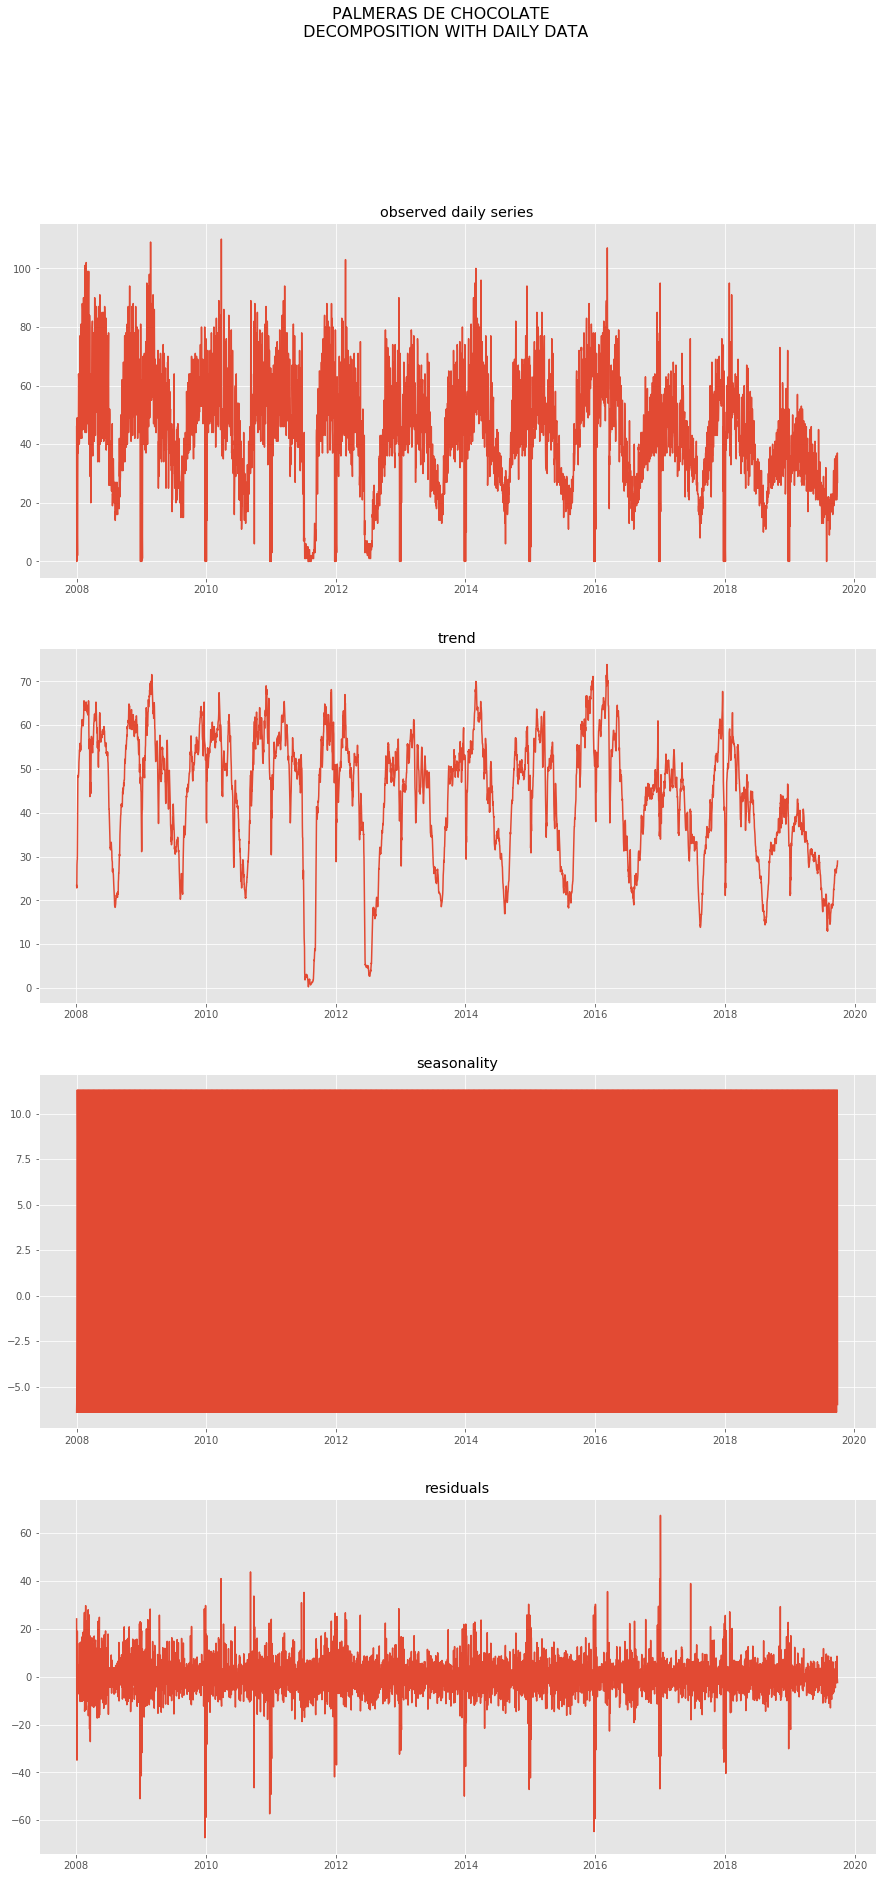

In [20]:
decomposition = seasonal.seasonal_decompose(palmera_choco['units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,30))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');


We cannot see a thing with the whole series, due to the constraints of the image. We are going to run the same procedure with just one year of data:

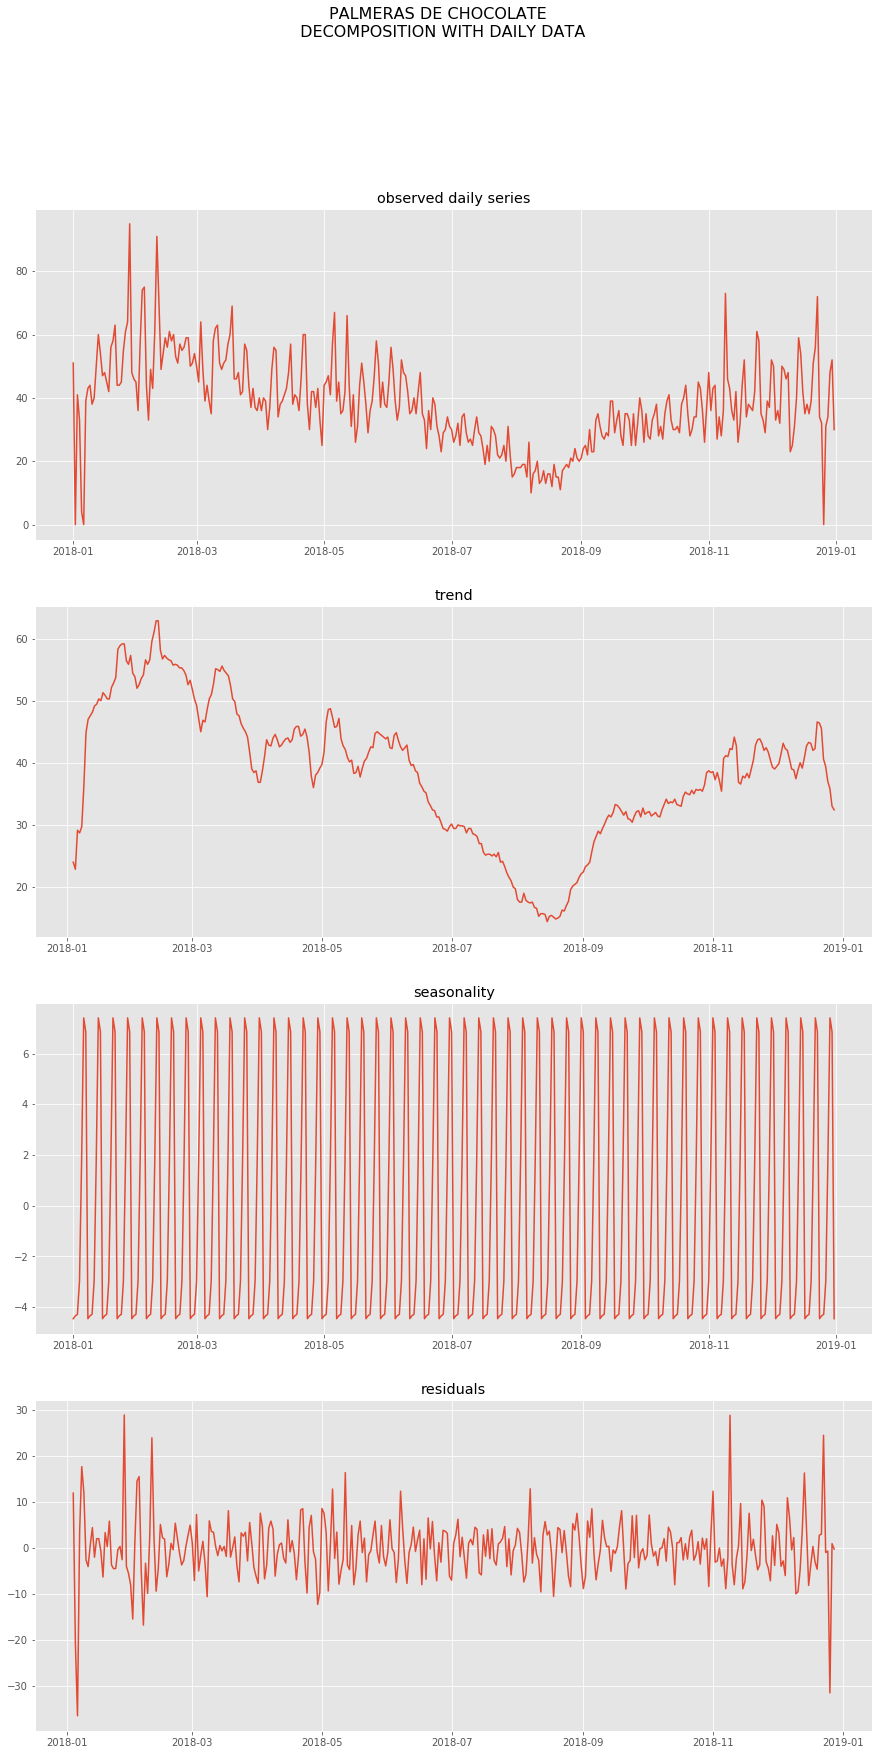

In [21]:
decomposition = seasonal.seasonal_decompose(palmera_choco.loc['2018','units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,28))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

From this decomposition we can extract two main conclusions:

* There is a strong seasonality week component.

* As we can see, the dcomposition is not working well for the series of the daily data. Let's see what it can do with the series of monthly averages:

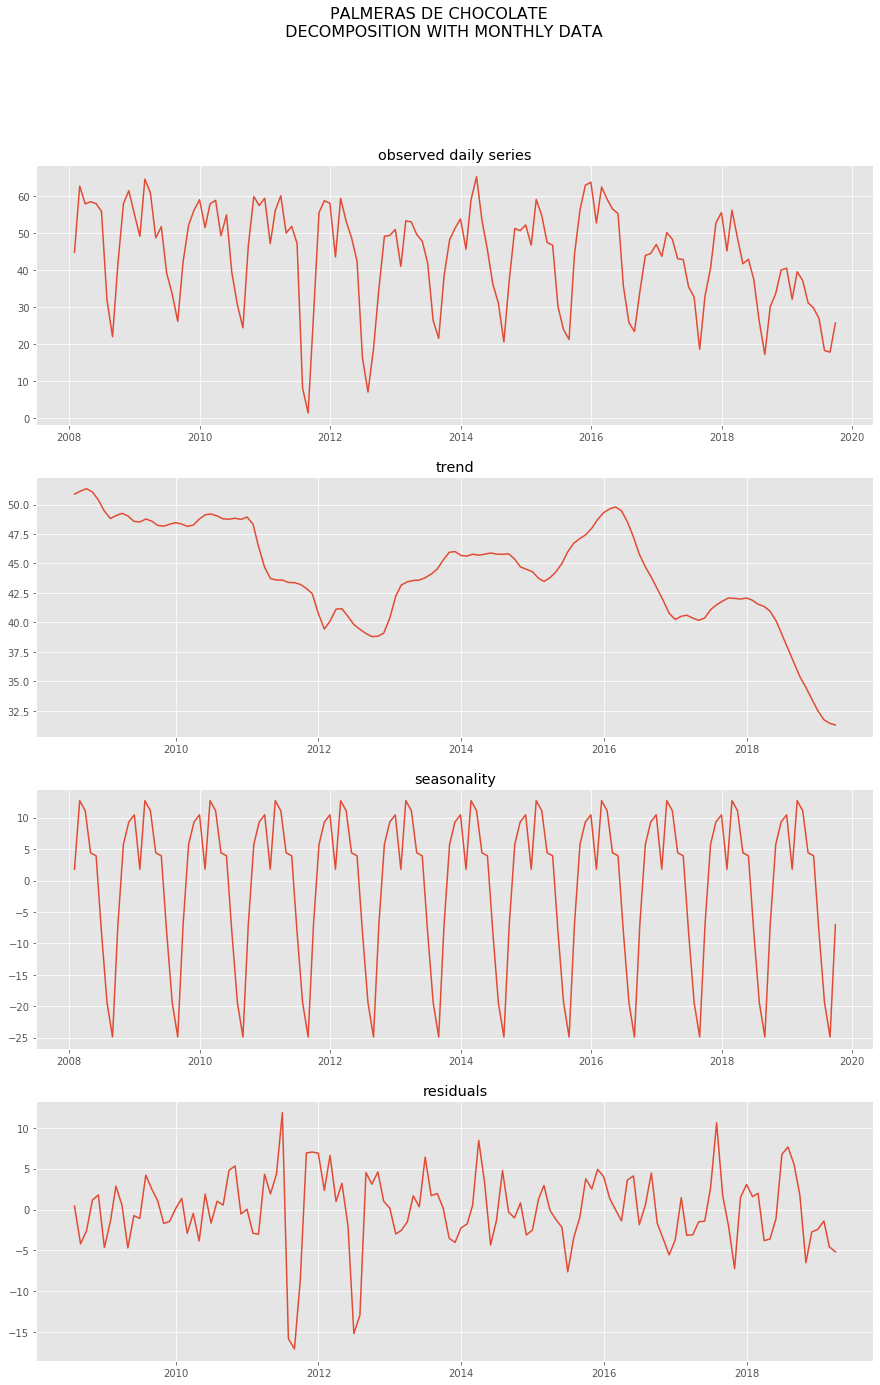

In [22]:
decomposition = seasonal.seasonal_decompose(monthly, model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,22))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH MONTHLY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');

# 2) Models application

### 2.0) Split Train-Test, Initialize Results Dictionary and setting benchmarks

In [23]:
# With Feature
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [24]:
# Without Features
# train_size = int(len(palmera_choco["units_ordered"]) * 0.95)
# train, test = palmera_choco.iloc[0:train_size,0], palmera_choco.iloc[train_size:,0]

For cross-validation purposes we are going to create a series of 10 randomly-picked intervals for our series.

The horizon to forecast will be of one week, which is the horizon demanded by the client.

Also, as we know, both exponential methods and ARIMA methods loose effectiveness (ARIMA methods loose everything but the trend) from a number of steps head on. So, trying to forecast big intervals ahead is not sensible.

For machine learning methods we will have to train one model for each day ahead that we want to predict, so, trying to predict many days in advance would require training the same number of different machine learning models, one for each day.

The data used to train our models will be the year before that week. Doing it so, we know that we loose the yearly-pattern seasonality that we found.

We initially don't care for this yearly seasonality.

The motives are as follow:
    
    1) for each model, including lags up to the 365 is clearly excessive.
    2) if it is necessary, to include the yearly seasonality would be easy, we would need only to differenciate the series with its 365th lag, and run this same models on the resulting series.
    3) we can also calculate the mean values for a cycle of 365 days and take it from the series, and operate with the resulting series.



In [27]:
series = palmera_choco["units_ordered"]

random.seed(17)

number_of_validations = 10
horizon = 7
data_for_pred = 365

cross_val_dict=dict()

for i in range(1,number_of_validations):

    ran_num = random.randint(365,len(series))
    ran_test_dates = series.reset_index().iloc[ran_num:ran_num + horizon]['order_date']
    ran_train_dates = series.reset_index().iloc[ran_num - data_for_pred:ran_num]['order_date']

    test = series[ran_test_dates]
    train = series[ran_train_dates]

    cross_val_dict['cv'+str(i)]=[train, test]

We create now an empty dictionary where we will input the error obtained by each method used.

In [28]:
# Error per model Dictionary
mse_all_models = {} 

We are now going to set our benchmarks for comparison:

**BENCHMARK 1:**

USING THE MEAN AS A GUESS:

Our first "model" will be: Using the mean (of the previous year) as a guess (the most basic model). This first value will provide us with a first tool to calibrate the other two models that we are going to use for benchmarking our time series and machine learning models.

As we said before, we are going to cross-validate our results running each model 10 times in different, randomly-picked, parts of the series, obtaining the mean of the mean squared errors commited, and the mean distribution of those mean squared errors:

In [29]:
mean_mse_mean = 0
mean_mse_series_mean =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_mean = train.mean()
    print("mean (model predicted value):", train_mean)
    squared_dif_series=(test - train_mean)**2
    print("MSE:", (squared_dif_series).mean())
    
    mean_mse_mean += (squared_dif_series).mean()
    
    mean_mse_series_mean += np.array(squared_dif_series)

mean_mse_mean = mean_mse_mean/number_of_validations
mean_mse_series_mean=pd.Series(mean_mse_series_mean/horizon)

print("mean MSE:", mean_mse_mean)

mean (model predicted value): 45.84109589041096
MSE: 67.3097906334611
mean (model predicted value): 43.106849315068494
MSE: 479.9069157976572
mean (model predicted value): 41.131506849315066
MSE: 145.14645256413698
mean (model predicted value): 42.13972602739726
MSE: 121.12480712007077
mean (model predicted value): 39.04109589041096
MSE: 399.6279119641852
mean (model predicted value): 42.73972602739726
MSE: 184.7428893118516
mean (model predicted value): 49.221917808219175
MSE: 249.27938449990629
mean (model predicted value): 40.76986301369863
MSE: 421.72732702463617
mean (model predicted value): 46.723287671232875
MSE: 71.69927029997586
mean MSE: 214.0564749215881


As we can see, there is a big dispersion in the MSE values, depending on the series used. This remarks the great importance of using cross-validation techniques when evaluating a model.

The MSE for this burd method is 214, aproximately.

We now plot the results for the last of our models:

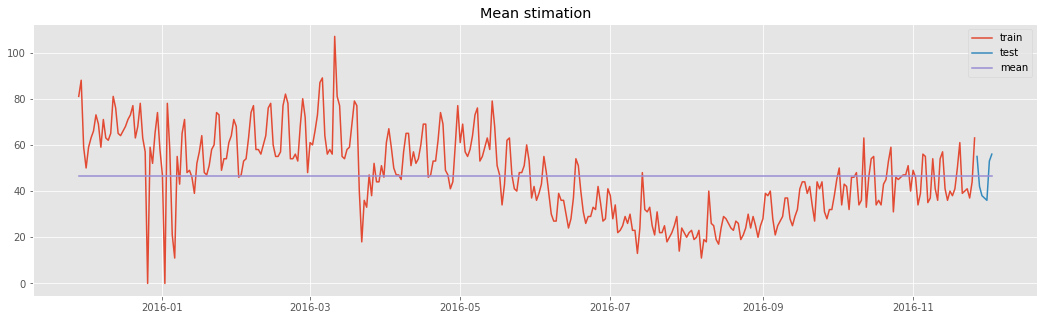

In [30]:
mean_model = pd.Series(train_mean, index = train.index.union(test.index))

plt.plot(train)
plt.plot(test)
plt.plot(mean_model)
plt.legend(['train','test','mean'])
plt.title("Mean stimation");

As we can see, the mean fails to capture any trend along the cycle, nor the weekly seasonality.

Evidently, the results should get better when replacing this simple average with a moving average that follows the series, but the purpose of this method is just setting a benchmark.

**BENCHMARK 2:**
    
MEAN OF JUST SAME DAYS OF THE WEEK:
    
Now we will use as our guess the mean of the values of the same weekday of the year before:

Firstly, to compare this model to the previous one, we are going to check it just for a particular one: the last scenario of the 10 randomly defined for our cross-validation purposes:

In [31]:
data = cross_val_dict['cv'+str(number_of_validations-1)]
train = data[0]
test = data[1]

In [32]:
train_means_by_weekday = train.groupby(train.index.weekday).mean()
print(train_means_by_weekday)
print("mean value for the same series:", train_mean)

order_date
0    41.730769
1    40.538462
2    43.250000
3    43.557692
4    49.288462
5    53.358491
6    55.211538
Name: units_ordered, dtype: float64
mean value for the same series: 46.723287671232875


As we can see, when compared with the general mean, we have now a series of values, one for each weekday, that present  certain dispersion. 

As now our guesses should be wiser, our median average error should go down, but any scenario is possible a priori.

In [33]:
mean_mse_mult_means = 0
mean_mse_series_mult_means =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_means_by_weekday = train.groupby(train.index.weekday).mean()
    test_df=test.reset_index()
    test_df['weekday'] = test.index.weekday
    df_train_means_by_weekday = train_means_by_weekday.reset_index()
    df_train_means_by_weekday.columns = ['weekday','prediction']

    test_result_merged = pd.merge(test_df, df_train_means_by_weekday, how='inner', on='weekday')
    test_result_merged.set_index(test_result_merged['order_date'], inplace=True)
    test_result_merged.sort_index(inplace=True)
    
    test_result_merged['Sq_error'] = (test_result_merged['units_ordered'] - test_result_merged['prediction'])**2

    mean_mse_mult_means += test_result_merged['Sq_error'].mean()
    
    mean_mse_series_mult_means += np.array(test_result_merged['Sq_error'])
    
    print("MSE:", test_result_merged['Sq_error'].mean())
    
mean_mse_mult_means = mean_mse_mult_means/number_of_validations
mean_mse_series_mult_means=pd.Series(mean_mse_series_mult_means/horizon)

print("mean MSE:", mean_mse_mult_means)

MSE: 31.359863402473696
MSE: 511.80309569801454
MSE: 97.65877348409457
MSE: 55.59690797331488
MSE: 306.0090280659588
MSE: 50.315730788640664
MSE: 221.35390289017883
MSE: 431.0688412810592
MSE: 17.64218908128593
mean MSE: 172.28083326650213


We can see that our predictions are better, because our mean error has dropped about 20%.

We want to remark, again, the dispersion of the values and the importance of using cross-validation techniques.

Now, we plot the values of the model against the real values, for the last iteration:

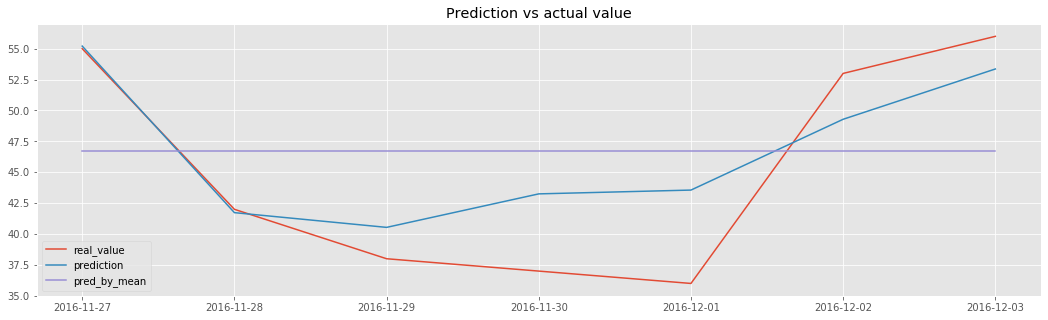

In [34]:
plt.plot(test_result_merged['units_ordered'])
plt.plot(test_result_merged['prediction'])
plt.plot(mean_model[test.index])
plt.legend(['real_value','prediction','pred_by_mean'])
plt.title('Prediction vs actual value');

As we can see, not only the mean error commited is lower, but also, the new benchmark model now adjusts well to the weekly seasonality. 

Let's check now how this is translated in the distributions of the mean errors:

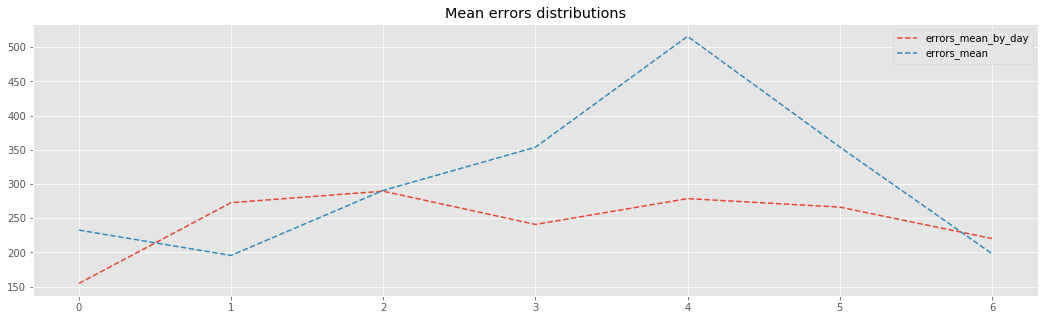

In [35]:
plt.plot(mean_mse_series_mult_means, '--')
plt.plot(mean_mse_series_mean, '--')
plt.legend(['errors_mean_by_day','errors_mean'])
plt.title('Mean errors distributions');

Our error is not only significantly lower, but also more uniform in its distribution along time, which is another factor to keep in mind.

**BENCHMARK 3:**
    
NAÎVE GUESS:
    
Now we are going to predict the values of our series just by using the last value available, again, for the same day of the week.

In [36]:
mean_mse_naive = 0
mean_mse_series_naive =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_bm3 = train[-horizon:]
    train_bm3.index = train_bm3.index + timedelta(days=7)
    pred_bm3 = test.shift(7)
    pred_bm3.fillna(0, inplace=True)
    pred_bm3[0:7] = pred_bm3[0:7] + train_bm3
    df_bm3 = pd.DataFrame(test)
    df_bm3['prediction'] = pred_bm3
    df_bm3['Sq_error'] = (df_bm3['units_ordered'] - df_bm3['prediction'])**2
    df_bm3['Sq_error'].mean()
    
    print("MSE:", df_bm3['Sq_error'].mean())
    
    mean_mse_naive += df_bm3['Sq_error'].mean()   
    mean_mse_series_naive += np.array(squared_dif_series)
    
mean_mse_naive = mean_mse_naive/number_of_validations
mean_mse_series_naive = pd.Series(mean_mse_series_naive/horizon)

print("mean MSE:", mean_mse_naive)

MSE: 81.28571428571429
MSE: 8.714285714285714
MSE: 28.428571428571427
MSE: 203.28571428571428
MSE: 95.85714285714286
MSE: 133.42857142857142
MSE: 182.85714285714286
MSE: 69.85714285714286
MSE: 28.0
mean MSE: 83.17142857142858


We can see that the mean MSE has halved. This suggests that guessing the values of the series with the same equivalent value from a week ago is a much better guess than using averages of any kind, what in turn, tells us that using just a small series of lags should give us good predictions.

Now, plotting the distributions:

Text(0.5, 1.0, 'Prediction vs actual value')

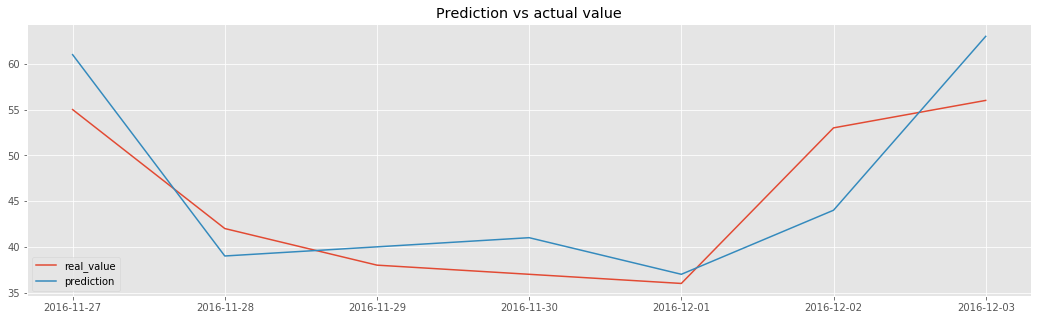

In [37]:
plt.plot(df_bm3['units_ordered'])
plt.plot(df_bm3['prediction'])
plt.legend(['real_value','prediction'])
plt.title('Prediction vs actual value')

We can see that the series again is capable of adjusting to the week pattern, as in the previous case.

Let's see now the distribution of errors:

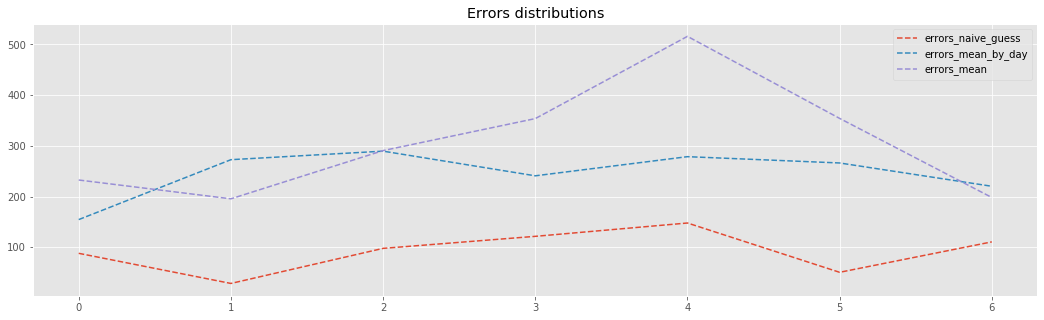

In [39]:
plt.plot(mean_mse_series_naive, '--')
plt.plot(mean_mse_series_mult_means, '--')
plt.plot(mean_mse_series_mean, '--')
plt.legend(['errors_naive_guess','errors_mean_by_day','errors_mean'])
plt.title('Errors distributions');

We can see that, in this case, not only we have a more homogeneous distribution of error, but also that they are all lower than in two previous cases.

**CONCLUSSIONS:**

**The information just previous to our forecast seems to be of greater value than historical data.**

**As we could see earlier, the weekly pattern is of great importance in this series, and has to be acknowledged.**

**Any model with a mean MSE greater than 82 will behave worse than a mere naîve guess (using the same value of the previous week). We will use this value as a threshold, but all three values (214 for the mean, 172 for the weekly means and 82 for the naîve guess) to compare with those of our methods.**

**From the disperssion of the values of MSE obtained for each of these three methods we can infer the great importance of doing cross-validation of the different methods.**

Now, we can start evaluating different methods.

### 2.1) TIME SERIES METHODS

Now, we can start using time series methods for our forecasts.

### 2.1.1) EXPONENTIAL MODELS

Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the unobserved components or states (level, trend, seasonal) change over time. Hence, these are referred to as state space models.

For each method there exist two models: one with additive errors and one with multiplicative errors. The point forecasts produced by the models are identical if they use the same smoothing parameter values. They will, however, generate different prediction intervals.

We label each state space model as ETS(.,.,.) for (Error, Trend, Seasonal). This label can also be thought of as ExponenTial Smoothing, where  the possibilities for each component are:

 - Error: Additive, Multiplicative
 - Trend: None, Additive, Additive and damped
 - Seasonal: None, Additive, Multiplicative
 
 
 This leads to the following map:
 
<img src=".\statespacemodels.png" style="width: 620px;">


Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are ETS(A,N,M), ETS(A,A,M), and ETS(A,Ad,M), due to division by values potentially close to zero in the state equations. We normally do not consider these particular combinations when selecting a model.

Models with multiplicative errors are useful when the data are strictly positive, but are not numerically stable when the data contain zeros or negative values. Therefore, multiplicative error models will not be considered if the time series is not strictly positive. In that case, only the six fully additive models will be applied.

Source:

https://otexts.com/fpp2/ets.html

So, being that our case, we will opt for an Additive Holt-Winters’ method (an exponential method with additive trend and additive seasonality) with additive errors.

This model is atractive for us, because it can detect trends and supports seasonality, which in our case is a weekly seasonality.

In [40]:
mean_mse_ES = 0
mean_mse_series_ES =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    ES_model = ExponentialSmoothing(train, trend='add', seasonal='add', damped=False, seasonal_periods=7)
    ES_model = ES_model.fit()

    ES_resid = ES_model.resid
    ES_aic = ES_model.aic

    ES_pred = ES_model.predict(start = test.index[0], end = test.index[-1])

    ES_mse = (test - ES_pred)**2
    
    print("MSE:", ES_mse.mean())
    
    mean_mse_ES += ES_mse.mean()   
    mean_mse_series_ES += np.array(ES_mse)
    
mean_mse_ES = mean_mse_ES/number_of_validations
mean_mse_series_ES = pd.Series(mean_mse_series_ES/horizon)

print("mean MSE:", mean_mse_ES)

MSE: 37.97813784094426
MSE: 23.118786827949652
MSE: 37.28492912056488
MSE: 82.18156886434507
MSE: 88.64884181627649
MSE: 59.552349818388926
MSE: 64.8388367151622
MSE: 97.18171770957238
MSE: 27.533529211870434
mean MSE: 51.831869792507426


As we can see, our MSE has gone is lower than the naîve guess value that we decided would be our threshold.

So, a priori, this model improves our situation over just selecting the last value for the same weekday, and would eligible.

Let's plot now the last prediction and the real series:

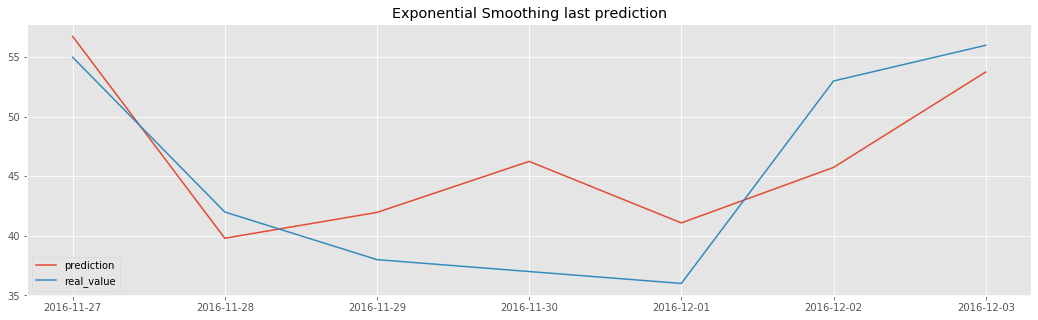

In [41]:
plt.plot(ES_pred)
plt.plot(test)
plt.legend(['prediction','real_value'])
plt.title("Exponential Smoothing last prediction");

And now, the resulting mean distribution of the MSE:

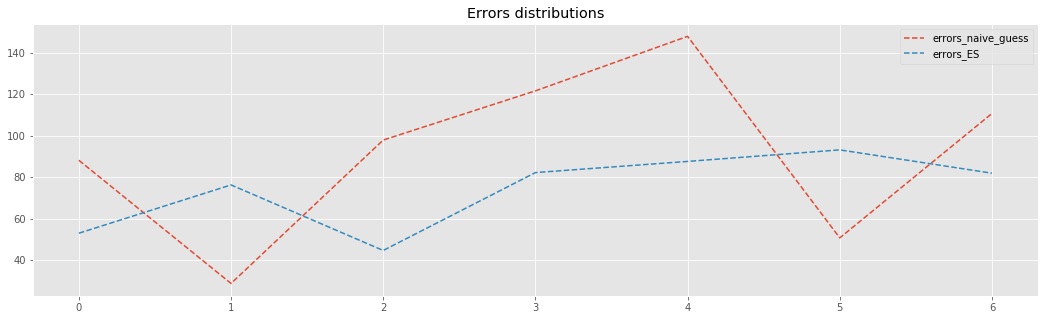

In [42]:
plt.plot(mean_mse_series_naive, '--')

plt.plot(mean_mse_series_ES, '--')

plt.legend(['errors_naive_guess','errors_ES'])
plt.title('Errors distributions');

### 2.1.2) ARIMA

Now we are going to try out the standard ARIMA model.

From the analysis performed during the first part of our notebook, (specifically, from the acf and pacf analysis) we know that an AR(7) model is in order.

We also know, as the series is already stationary, that no differencing would be needed, although can be convenient.

Let's study the matter a little more in depth:

**CHECKING FOR DIFFERENCING:**

WWe are now going to check the optimal order of differencing for our series. We will follow the following rules:

Identifying the order of differencing and the constant:

Rule 1: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.

Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.

Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. (Not always, though. Slightly too much or slightly too little differencing can also be corrected with AR or MA terms. See rules 6 and 7.)

Rule 4: A model with no orders of differencing assumes that the original series is stationary (among other things, mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).

Rule 5: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.

Source: https://people.duke.edu/~rnau/arimrule.htm
    
If the differenced series presents a negative correlation with its lag-1 value, the series would be slighly overdifferenced:

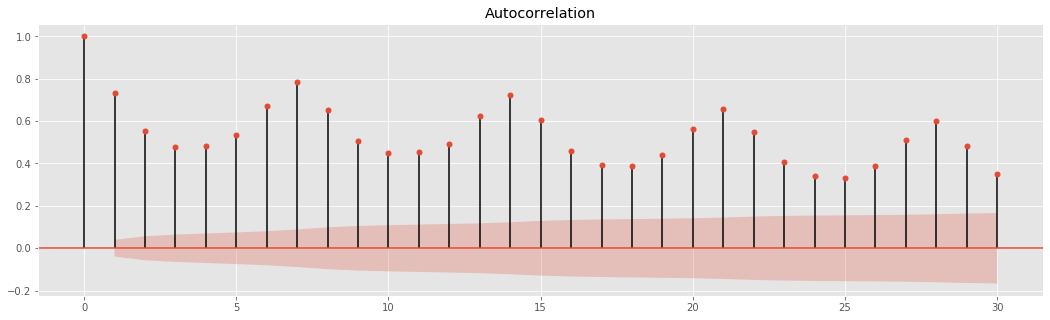

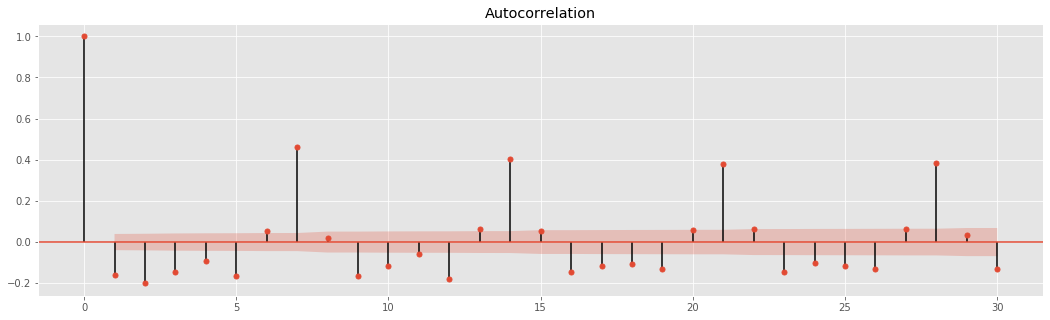

In [90]:
dif_series_1 = series.diff(1).dropna()
plot_acf(series, lags = 30, alpha= 0.01)
plot_acf(dif_series_1, lags = 30, alpha= 0.01);

In [88]:
print(series.std())
print(dif_series_1.std())

18.076183830888187
13.226164709895148


Following the rules, the order of differencing for our models can only be 0 or 1.

0 because it is already stationary, and an AR(7) model seems appropriate to deal with the existing autocorrelations up to lag 7, but, as shown above, it seems also appropriate to use a d=1, to remove the effect of lag 1 in the series, and let the AR part of the model deal with the rest of the autocorrelations.

we are going to try out both strategies.

**STIMATING THE MA COEFFICIENTS:**

What we don't know yet is the coefficient for the MA part of the model.

As we know, if the acf had returned a spike (for instance, at lag 1), but not any other spike at any multiples of this lag, that would indicate the existence of an MA component, of order, the order of the lag (in case of the presence of a spike at lag 1, and not any other lag, that would lead us to a MA(1) model).

Nevertheless, when there are effects of an autoregression, they can compound to the effects of a possible MA.

Or as it is expressed in https://people.duke.edu/~rnau/411arim3.htm:

*AR and MA signatures: If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. You will probably find that an AR signature is commonly associated with positive autocorrelation at lag 1--i.e., it tends to arise in series which are slightly underdifferenced. The reason for this is that an AR term can act like a "partial difference" in the forecasting equation. For example, in an AR(1) model, the AR term acts like a first difference if the autoregressive coefficient is equal to 1, it does nothing if the autoregressive coefficient is zero, and it acts like a partial difference if the coefficient is between 0 and 1. So, if the series is slightly underdifferenced--i.e. if the nonstationary pattern of positive autocorrelation has not completely been eliminated, it will "ask for" a partial difference by displaying an AR signature.

(...)

*In principle, any autocorrelation pattern can be removed from a stationarized series by adding enough autoregressive terms (lags of the stationarized series) to the forecasting equation, and the PACF tells you how many such terms are likely be needed. However, this is not always the simplest way to explain a given pattern of autocorrelation: sometimes it is more efficient to add MA terms (lags of the forecast errors) instead. The autocorrelation function (ACF) plays the same role for MA terms that the PACF plays for AR terms--that is, the ACF tells you how many MA terms are likely to be needed to remove the remaining autocorrelation from the differenced series. If the autocorrelation is significant at lag k but not at any higher lags--i.e., if the ACF "cuts off" at lag k--this indicates that exactly k MA terms should be used in the forecasting equation. In the latter case, we say that the stationarized series displays an "MA signature," meaning that the autocorrelation pattern can be explained more easily by adding MA terms than by adding AR terms.*

For identifying the numbers of the MA terms we will follow the following rules:

Identifying the numbers of AR and MA terms:

Rule 6: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

Rule 7: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

Rule 8: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.

Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.

Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

So, from the above acf, we can see that, if we go for a d=0 model, the MA is difficult to determine (we will pick MA=0 and MA=1 in this case)

For a d=1 model, it seems that the we should go for a MA=7 model.

So, our candidates should be ARIMA(7,0,0), ARIMA(7,0,1), ARIMA(7,0,7), ARIMA(7,1,0), ARIMA(7,1,1) and ARIMA(7,1,7)

To these models, we are going to add the ARIMA(1,0,0) and ARIMA(2,0,1) models as control for the AIC criterion (maybe we can do good enough using less information, and we want to check that we are doing things right).

(We need to keep in mind the need for invertibility of the coefficients of the MA model)

In [222]:
data = cross_val_dict['cv'+str(number_of_validations-1)]
train = data[0]
test = data[1]

orders=[(1,0,0),(2,0,1),(7,0,0),(7,0,1),(7,0,7),(7,1,0),(7,1,1),(7,1,7)]

In [217]:
order = (7,1,7)

ARIMA_model = ARIMA(train, order = order)
ARIMA_model = ARIMA_model.fit()

print(ARIMA_model.summary)

ARIMA_resid = ARIMA_model.resid
ARIMA_aic = ARIMA_model.aic

if order[1] == 0:
    ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1])
else:
    ARIMA_pred = ARIMA_model.predict(start = test.index[0], end = test.index[-1], typ='levels')

ARIMA_mse = (test - ARIMA_pred)**2

print(ARIMA_mse.mean())
print(ARIMA_aic)

<bound method ARMAResults.summary of <statsmodels.tsa.arima_model.ARIMAResults object at 0x000001FC020B02B0>>
22.766072745138395
2696.3986374281685


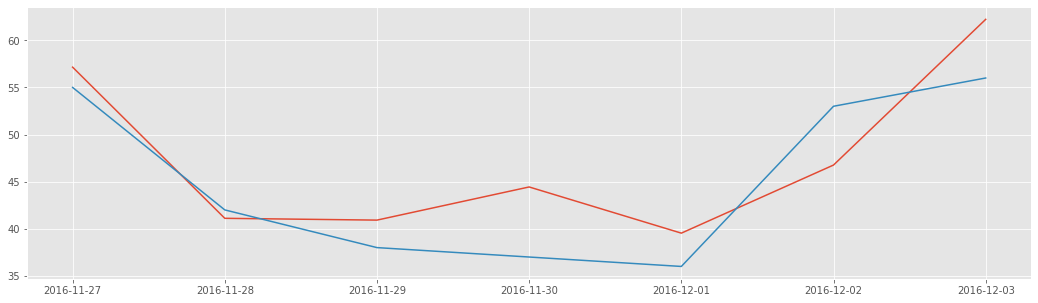

In [218]:
# Plot the original series and the forecasted series
plt.plot(ARIMA_pred)
plt.plot(test)

We define now a function that obtains all this values for us:

In [219]:
# evaluate an ARIMA model:

def eval_arima_model(arima_order, train , test):
    
    arima_order=tuple(arima_order)

    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    
    model_summary = model_fit.summary

    model_resid = model_fit.resid
    model_aic = model_fit.aic
    
    if arima_order[1] == 0:
        model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1])
    else:
        model_prediction = model_fit.predict(start = test.index[0], end = test.index[-1], typ='levels')

    # calculate out of sample error
    model_error = mean_squared_error(test, model_prediction)
    
    return model_summary, model_prediction, model_resid, model_aic, model_error

Checking that the function works propperly:

In [223]:
data = cross_val_dict['cv'+str(3)]
train = data[0]
test = data[1]

In [228]:
ARIMA_summary, ARIMA_resid, yhat, ARIMA_aic, ARIMA_error = eval_arima_model((7,1,7), train, test)
print(ARIMA_error)
print(ARIMA_aic)
print(ARIMA_summary)
# print(ARIMA_resid)
# print(yhat)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

Now, we use this function to try out several different combinations for the parameters of the ARIMA model:

In [ ]:
mean_mse_mean = 0
mean_mse_series_mean =np.array([0.0]*horizon)

for key, data in cross_val_dict.items():
    
    train = data[0]
    test = data[1]

    train_mean = train.mean()
    print("mean (model predicted value):", train_mean)
    squared_dif_series=(test - train_mean)**2
    print("MSE:", (squared_dif_series).mean())
    
    mean_mse_mean += (squared_dif_series).mean()
    
    mean_mse_series_mean += np.array(squared_dif_series)

mean_mse_mean = mean_mse_mean/number_of_validations
mean_mse_series_mean=pd.Series(mean_mse_series_mean/horizon)

print("mean MSE:", mean_mse_mean)

In [229]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(orders, train , test):
    print("starting...") 
#     train = train.astype('float32')
#     test = test.astype('float32')
    model_summ, model_pred, model_res, model_aic, model_error  = None, None, None, None, float("inf")
    b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA = None, None, None, None, float("inf")

    for order in orders:
        
        mean_mse_ARIMA, mean_ARIMA_aic = 0, 0
        mean_mse_series_ARIMA = np.array([0.0]*horizon)
        
        for key, data in cross_val_dict.items():
    
            train = data[0]
            test = data[1]
            
            try:
                model_summ, model_pred, model_res, model_aic, model_error = eval_arima_model(order, train, test)
                
            except:
                print("model not good to be fitted")
                break

            squared_dif_series = (model_pred - test)**2

            mean_mse_ARIMA += model_error
            mean_ARIMA_aic += model_aic

            mean_mse_series_ARIMA += np.array(squared_dif_series)

        mean_mse_ARIMA = mean_mse_ARIMA/number_of_validations
        mean_ARIMA_aic = mean_ARIMA_aic/number_of_validations
        mean_mse_series_ARIMA=pd.Series(mean_mse_series_ARIMA/horizon)

        print('ARIMA %s MSE=%s AIC=%s' % (order, mean_mse_ARIMA, mean_ARIMA_aic))

        if mean_mse_ARIMA < mean_mse_ARIMA:
            
            b_mean_mse_ARIMA = mean_mse_ARIMA
            b_mean_ARIMA_aic = mean_ARIMA_aic

            b_model_summ, b_model_pred, b_model_res = model_summ, model_pred, model_res
            
            b_order = order

        print('ARIMA %s MSE=%s AIC=%s' % (order, model_error, model_aic))
                    
    print('Best ARIMA %s MSE=%s AIC=%s' % (b_order, b_error, b_model_aic))
    
    return b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA

In [230]:
b_model_summ, b_model_pred, b_model_res, b_mean_ARIMA_aic, b_mean_mse_ARIMA = evaluate_models(orders, train, test)

starting...
ARIMA (1, 0, 0) MSE=184.95849879308605 AIC=2569.1920691029427
ARIMA (1, 0, 0) MSE=139.8979172197667 AIC=2838.2254349054247
ARIMA (2, 0, 1) MSE=130.81281186776187 AIC=2535.378393810345
ARIMA (2, 0, 1) MSE=70.25146199904472 AIC=2783.189429084604
ARIMA (7, 0, 0) MSE=60.10072459168049 AIC=2446.696278686391
ARIMA (7, 0, 0) MSE=20.316819328780717 AIC=2710.3379705983234
ARIMA (7, 0, 1) MSE=60.82730444445019 AIC=2446.625987546875
ARIMA (7, 0, 1) MSE=20.350031020474482 AIC=2708.191389651665
model not good to be fitted
ARIMA (7, 0, 7) MSE=4.378290348820942 AIC=265.5402076786812
ARIMA (7, 0, 7) MSE=43.78290348820942 AIC=2655.402076786812
ARIMA (7, 1, 0) MSE=57.61146634759315 AIC=2439.861708028141
ARIMA (7, 1, 0) MSE=18.08027835775068 AIC=2700.252342463473
ARIMA (7, 1, 1) MSE=56.57989433476583 AIC=2441.002790691831
ARIMA (7, 1, 1) MSE=18.000927415659046 AIC=2702.2155162569475
model not good to be fitted
ARIMA (7, 1, 7) MSE=4.579879406195124 AIC=264.8687247298097
ARIMA (7, 1, 7) MSE=45.

UnboundLocalError: local variable 'b_order' referenced before assignment

In [208]:
b_error

18.000927415659046

### 2.3) SARIMA

### 2.2) PROPHET

In [ ]:
train_for_prophet = train.reset_index()
train_for_prophet = train_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
palmera_choco_prophet_model = Prophet(interval_width=0.95)
palmera_choco_prophet_model.fit(train_for_prophet)


palmera_choco_forecast = palmera_choco_prophet_model.make_future_dataframe(periods=36, freq='MS')
palmera_choco_forecast = palmera_choco_prophet_model.predict(palmera_choco_forecast)

plt.figure(figsize=(18, 6))
palmera_choco_prophet_model.plot(palmera_choco_forecast, xlabel = 'Date', ylabel = 'Orders')
plt.title('Palmera Chocolate- Oreders Forecast')

In [ ]:
test_for_prophet = test.reset_index()
test_for_prophet = test_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
predictions = palmera_choco_prophet_model.predict(test_for_prophet)

In [ ]:
mse_prophet = mean_squared_error(test_for_prophet["y"], predictions["yhat"])
mse_prophet

In [ ]:
df_cv = cross_validation(palmera_choco_prophet_model, initial='366 days', period='365 days', horizon = '20 days')
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
df_p['mse'].plot()

In [ ]:
mse_all_models["Prophet"] = mse_prophet

### 2.2) RANDOM FOREST

Lets now try rarandom forest with only the time series as input. The steps we will need to follow are:

1. Transform the data: each row should contain the features (previous days, matches, etc)
2. Fit the model with train
3. Predict with test
4. Evaluate the error.

Lets start creating the function that will transform the data, which was adapted from the following site: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

In [ ]:
def data_transformation(series, n_lag, lead_time):
    """ Takes a series, a number of lag observations to use as input, 
    and a forecast lead time to predict, then will return a list of input/out 
    rows drawn from the series """

    data = list()
    # enumerate observations and create input/output patterns
    for i in range(n_lag, len(series)):
        end_ix = i + (lead_time - 1)
        # check if can create a pattern
        if end_ix >= len(series):
            break
        # retrieve input and output
        start_ix = i - n_lag
        row = series[start_ix:i] + [series[end_ix]]
        data.append(row)
    return list(data)

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction, as well as the gap between the prediction and the data:

In [ ]:
# Take into account the las 365 days
previous_days = 365

#Predict the next day
predict_n_plus = 1

In [ ]:
#Required by data_transformation
train_list = list(train)
test_list = list(test)

#Lets keep the index
index_train = train[(previous_days+predict_n_plus-1):].index
index_test = test[(previous_days+predict_n_plus-1):].index

#Transform test and train and keeps the 
train_rf = pd.DataFrame(data_transformation(train_list, previous_days, predict_n_plus), index = index_train)
test_rf = pd.DataFrame(data_transformation(test_list, previous_days, predict_n_plus), index = index_test)

# Create random forest object
clf = RandomForestRegressor(max_depth=4)

# Split the features form the target variable
X_train = train_rf[train_rf.columns[:-1]]
y_train = train_rf[train_rf.columns[-1]]

X_test = test_rf[test_rf.columns[:-1]]
y_test = test_rf[test_rf.columns[-1]]

# Train the model
clf.fit(X_train,y_train)

# Calculate the error
mse = mean_squared_error(clf.predict(X_test),y_test)
mse

Oh lah lah, fantastic mse! 

Lets have a look both the predicted series agains the observed:

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test))
ax1.plot(list(y_test))
ax1.legend(['Prediction',"Observed"])

Its a bit complicated to see anything, lets zoom at both the start and end:

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test)[:100])
ax1.plot(list(y_test)[:100])
ax1.legend(['Prediction',"Observed"])

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test)[-100:])
ax1.plot(list(y_test)[-100:])
ax1.legend(['Prediction',"Observed"])

As expected the closer the observations are to the trained data, the better it looks.

Lets now have a look at what is the model doing with the input variables:

In [ ]:
clf.feature_importances_

In [ ]:
max_val = clf.feature_importances_.max()
max_val_day = list(clf.feature_importances_).index(max_val)

print(f"Most important feature is day {max_val_day}, with a total weight of {max_val}")

This is both expected and unexpected. What we expected is to see the previous value as the most relevant one for the model, however, what we didn't expect is so many features adding 0 value.

Nonetheless this basic Random Forest is just the beginning, lets now play with hyperparameters input data etc...

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction. From the time series analysis that we did before, we have some insight that -7 days, and -365 days may be very important, however we don't know which model will perform best, hence we will train with different timeframes. 

In [ ]:
previous_days = [1,7,30,365]
predict_n_plus = [1,2,3,4,5,6,7]


Lets now transform now create another function that:
1. Splits train and test into the right formats required by the model.
2. Trains the model.
3. Predicts and evaluate.

And lets save the results to see which is the best performing model:


In [ ]:
def train_test_to_random_forest_shape (previous_days, train, test, predict_n_plus):
    # Conversion to list is needed for the transformation function
    train_list = list(train)
    test_list = list(test)
    
    #Lets keep the index
    index_train = train[(previous_days+predict_n_plus-1):].index
    index_test = test[(previous_days+predict_n_plus-1):].index
    
    #Transform test and train and keeps the 
    train_rf = pd.DataFrame(data_transformation(train_list, previous_days, predict_n_plus), index = index_train)
    test_rf = pd.DataFrame(data_transformation(test_list, previous_days, predict_n_plus), index = index_test)
    
    return(train_rf,test_rf)


No it is time to iterate over the number of previous days, and evaluate the different models:

In [ ]:
random_forst_errors = {}
for d in previous_days:
    for p in predict_n_plus:
        # Transform the data
        (train_rf,test_rf) = train_test_to_random_forest_shape(d,train,test, p)
        # Create random forest object
        clf = RandomForestRegressor(max_depth=4)

        # Split the features form the target variable
        X_train = train_rf[train_rf.columns[:-1]]
        y_train = train_rf[train_rf.columns[-1]]

        X_test = test_rf[test_rf.columns[:-1]]
        y_test = test_rf[test_rf.columns[-1]]

        # Train the model
        clf.fit(X_train,y_train)

        # Calculate the error
        mse = mean_squared_error(clf.predict(X_test),y_test)

        random_forst_errors[str(d) + " : " + str(p)] = mse

random_forst_errors

Improvements:
- One model per day of future prediction (so.. one model for n+1, one model for n+2, etc)
- Aggregate by week all data.
- Multivarient Random Forest
- https://www.r-bloggers.com/time-series-forecasting-with-random-forest/
- Retraining removing columns with 0

Transfer learning to other 